In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from salishsea_tools import viz_tools, places, visualisations
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar
import cmocean

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

##### Load files from monthly averages

In [3]:
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(0, 900), 'x': slice(0, 400)}
e3t, tmask = [mask[var].isel(z=slice(None, 40),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['GRMICZDIAT', 'GRMICZMRUB', 'GRMICZPHY', 'GRMICZPON', 'GRMICZMICZ','microzooplankton']

# Temporary list dict
data = {}

# Permanent aggregate dict
aggregates = {var: {} for var in variables}

# Loop through years
for year in tqdm(years):
    
    # Initialize lists
    for var in variables: data[var] = []
    
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        
       
        # Load grazing variables
        with xr.open_dataset(prefix + '_dia2_T.nc') as ds:
        
            for var in ['GRMICZDIAT', 'GRMICZMRUB', 'GRMICZPHY', 'GRMICZPON', 'GRMICZMICZ']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 40), **slc).values * e3t).sum(axis=1).data)
    
    
        # Load grazing variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            for var in ['microzooplankton']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 40), **slc).values * e3t).sum(axis=1).data)
            
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

# Add total grazing fields
aggregates['TotalGrazing'] = {}
variables.append('TotalGrazing')
for year in years:
    aggregates['TotalGrazing'][year] = sum(aggregates[var][year] for var in ['GRMICZDIAT', 'GRMICZMRUB', 'GRMICZPHY', 'GRMICZPON', 'GRMICZMICZ'])

# Calculate 5 year mean and anomalies
for var in variables:
    aggregates[var]['mean'] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
    for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var]['mean']

  0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(0, 900), 'x': slice(0, 400),'deptht':slice(None, 40)} 
e3t, tmask = [mask[var].rename({'t':'time_counter','z':'deptht'}).isel(**slc) for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['votemper']


# Temporary list dict
data2 = {}

# Permanent aggregate dict
aggregates2 = {var: {} for var in variables}

# Loop through years
for year in tqdm(years):
    
    # Initialize lists
    for var in variables: data2[var] = []
    
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_grid_T.nc') as ds:
        
            for var in ['votemper']:
                data2[var].append((ds[var].isel(**slc)*e3t*tmask).sum(dim='deptht')/((e3t*tmask).sum(dim='deptht')).data)
   
                #TQ10 = np.exp(0.07 * (ds[var] - 20))
                
                #data2['TQ10'].append(TQ10)
    
    # Concatenate months
    for var in variables: aggregates2[var][year] = np.concatenate(data2[var]).mean(axis=0)


# Calculate climatological mean and anomalies
for var in variables:
    aggregates2[var]['mean'] = np.concatenate([aggregates2[var][year][None, ...] for year in years]).mean(axis=0)
    for year in years: aggregates2[var][year] = aggregates2[var][year] - aggregates2[var]['mean']

  0%|          | 0/5 [00:00<?, ?it/s]

In [5]:

#TQ10 = np.exp(0.07 * (ds[var] - 20))
        
#data['TQ10'].append(TQ10)


In [6]:
aggregates2['votemper']['mean']

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [7]:
print(np.shape(aggregates['TotalGrazing'][2015][:]))

(898, 398)


In [8]:
aggregates['GRMICZDIAT'][2015]*86400

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
# Reset variables for plotting
tmask = tmask[0, 0, ...]
variables = ['GRMICZDIAT', 'GRMICZMRUB', 'GRMICZPHY', 'GRMICZPON', 'GRMICZMICZ','TotalGrazing','microzooplankton','votemper']

In [10]:
aggregates['GRMICZDIAT'][2015]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
votemper=(np.ma.masked_where(tmask==0,((aggregates2['votemper']['mean']))))

In [12]:
TQ10 = np.exp(0.07 * (votemper - 20))

In [13]:
# For Microzooplankton
eff = 0.6
sloppy = 1 - eff
pontrans = 1
trans = 0.47

uZoo_graz_PON = aggregates['GRMICZPON']['mean'] * sloppy * pontrans
uZoo_graz_diatoms = aggregates['GRMICZDIAT']['mean'] * sloppy * trans
uZoo_graz_uzoo = aggregates['GRMICZMICZ']['mean'] * sloppy * trans
uZoo_graz_flag = aggregates['GRMICZPHY']['mean'] * sloppy * trans
uZoo_graz_mrub = aggregates['GRMICZMRUB']['mean'] * sloppy * trans

# Mortality
mort_rate = 0.5e-6 # at 20o TQ10 is temperature correction
#mort_to_PON = (mort_rate * aggregates['TQ10']['mean'] 
#        * aggregates['microzooplankton']['mean']) * trans
# problem TQ10 is all nans!
mort_to_PON = (mort_rate * TQ10 
        * aggregates['microzooplankton']['mean']) * trans


In [14]:
total_from_uZ=(uZoo_graz_PON + uZoo_graz_diatoms +
         uZoo_graz_uzoo + uZoo_graz_flag+mort_to_PON)

In [15]:
total_from_uZ.max()

5.612060642741056e-05

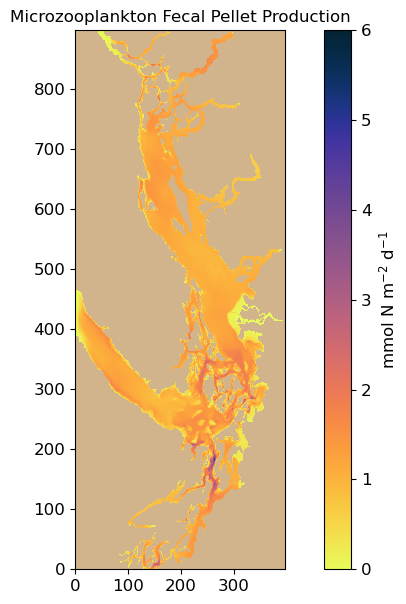

In [17]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')
vmin=0
vmax=6
cmap1=cmocean.cm.thermal_r
cmap1.set_bad('tan')
il=0

fig,ax=plt.subplots(1,1,figsize=(10,7))
#fig.suptitle('Annual Anomalies Mesozoop Feeding on Diatoms', fontsize=16)
m0=ax.pcolormesh(np.ma.masked_where(tmask==0,((total_from_uZ*86400))),cmap=cmap1,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax,coords='grid')
ax.set_title('Microzooplankton Fecal Pellet Production')
fig.colorbar(m0,ax=ax,label='mmol N m$^{-2}$ d$^{-1}$')

